In [1]:
# 페이스북에서 만든 fbprophet 모듈
# 윈도우 visual c++ build tools 설치해야 함
# pip install pystan, pip install prophet, 
# prophet 설치가 안되면 conda install -c conda-forge fbprophet
# pip install pandas_datareader
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from fbprophet import Prophet
from datetime import datetime

Importing plotly failed. Interactive plots will not work.


In [2]:
# matplotlib 한글 문제 해결
path = 'c:/Windows/Fonts/malgun.ttf'
import platform
from matplotlib import font_manager, rc
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('sorry')
    
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# https://raw.githubusercontent.com/PinkWink/DataScience/master/data/08.%20PinkWink%20Web%20Traffic.csv
# csv 파일을 dataframe으로 읽기
# ,를 천 단위로 인식
# column name을 date, hit로 명명
# 첫번째 컬럼을 index로
# hit 데이터가 있는 것만 읽어들이기
pinkwink_web = pd.read_csv('./08. PinkWink Web Traffic.csv',
                          encoding='utf-8', thousands=',',
                          names=['date','hit'], index_col=0)
pinkwink_web = pinkwink_web[pinkwink_web['hit'].notnull()]
pinkwink_web.head()

,hit
date,
16. 7. 1.,766.0
16. 7. 2.,377.0
16. 7. 3.,427.0
16. 7. 4.,902.0
16. 7. 5.,850.0


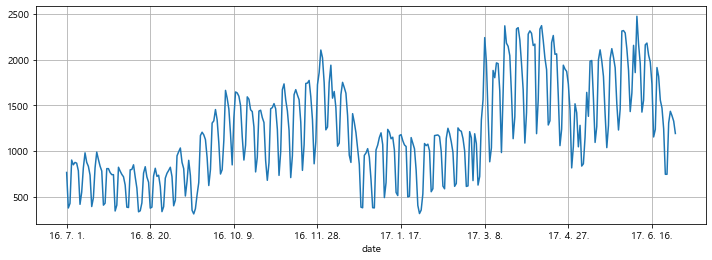

In [4]:
pinkwink_web['hit'].plot(figsize=(12,4), grid=True);

In [5]:
time = np.arange(0,len(pinkwink_web))
traffic = pinkwink_web['hit'].values # numpy array로 저장

fx = np.linspace(0, time[-1], 1000) # time을 1000개로 나누기

In [6]:
def error(f, x, y):
    return np.sqrt(np.mean((f(x)-y)**2)) # f라는 함수 정의는 나중에

In [7]:
# np.poly1d -> 1변수 다항식 (one-dimensional polynomial class)의 계수로 이루어진 함수를 만들어주는 함수
p = np.poly1d([1,2,3])
print(np.poly1d(p))

   2
1 x + 2 x + 3


In [8]:
fp1 = np.polyfit(time, traffic, 1)
f1 = np.poly1d(fp1) # fitting 함수의 계수

fp2 = np.polyfit(time, traffic, 2)
f2 = np.poly1d(fp2)

fp3 = np.polyfit(time, traffic, 3)
f3 = np.poly1d(fp3)

fp15 = np.polyfit(time, traffic, 15)
f15 = np.poly1d(fp15)

print(error(f1, time, traffic))
print(error(f2, time, traffic))
print(error(f3, time, traffic))
print(error(f15, time, traffic))

430.85973081109637
430.62841018946955
429.53280466762925
330.4777308491587


In [9]:
print(fp3)

[ 3.34072153e-05 -1.96619824e-02  6.11714142e+00  5.67195752e+02]


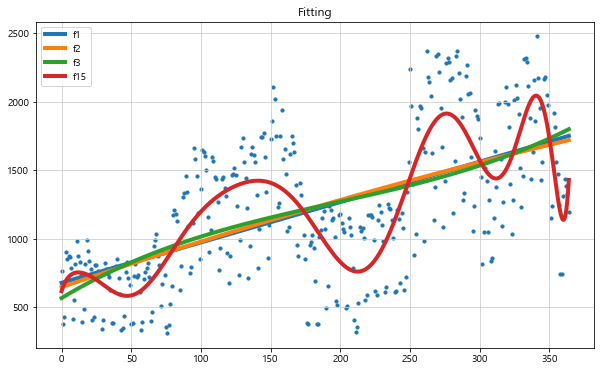

In [10]:
plt.figure(figsize=(10,6))
plt.scatter(time, traffic, s=10) # scatter, size 10

plt.plot(fx, f1(fx), lw=4, label='f1') # linewidth -> lw
plt.plot(fx, f2(fx), lw=4, label='f2')
plt.plot(fx, f3(fx), lw=4, label='f3')
plt.plot(fx, f15(fx), lw=4, label='f15')

plt.grid(True, linestyle='-', color='0.8') # color 1에 가까울수록 반투명
plt.legend(loc='best') # location, best
plt.title('Fitting')
plt.show()

In [11]:
pinkwink_web.index

Index(['16. 7. 1.', '16. 7. 2.', '16. 7. 3.', '16. 7. 4.', '16. 7. 5.',
       '16. 7. 6.', '16. 7. 7.', '16. 7. 8.', '16. 7. 9.', '16. 7. 10.',
       ...
       '17. 6. 21.', '17. 6. 22.', '17. 6. 23.', '17. 6. 24.', '17. 6. 25.',
       '17. 6. 26.', '17. 6. 27.', '17. 6. 28.', '17. 6. 29.', '17. 6. 30.'],
      dtype='object', name='date', length=365)

In [29]:
pinkwink_web.index

Index(['16. 7. 1.', '16. 7. 2.', '16. 7. 3.', '16. 7. 4.', '16. 7. 5.',
       '16. 7. 6.', '16. 7. 7.', '16. 7. 8.', '16. 7. 9.', '16. 7. 10.',
       ...
       '17. 6. 21.', '17. 6. 22.', '17. 6. 23.', '17. 6. 24.', '17. 6. 25.',
       '17. 6. 26.', '17. 6. 27.', '17. 6. 28.', '17. 6. 29.', '17. 6. 30.'],
      dtype='object', name='date', length=365)

In [25]:
# prophet 모듈을 이용한 forecast 예측
# pinkwink_web 에서 날짜(index)와 방문수(hit)만 따로 저장

df = pd.DataFrame({'ds':pinkwink_web.index, 'y':pinkwink_web['hit']})
df.head()
# date index는 따라 다님

,ds,y
date,,
16. 7. 1.,16. 7. 1.,766.0
16. 7. 2.,16. 7. 2.,377.0
16. 7. 3.,16. 7. 3.,427.0
16. 7. 4.,16. 7. 4.,902.0
16. 7. 5.,16. 7. 5.,850.0


In [26]:
# reset_index를 이용해서 index를 0부터 다시 지정 가능
df.reset_index(inplace=True)

# del 함수로 컬럼 삭제
del df['date']
df.head()



,ds,y
0,16. 7. 1.,766.0
1,16. 7. 2.,377.0
2,16. 7. 3.,427.0
3,16. 7. 4.,902.0
4,16. 7. 5.,850.0


In [27]:
# 날짜 형식을 pd.to_datetime 함수를 이용해서 표준 날짜 표시 방법 (0000-00-00)으로 바꾼다!
df['ds'] = pd.to_datetime(df['ds'], format='%y. %m. %d.') 
df.head()

,ds,y
0,2016-07-01,766.0
1,2016-07-02,377.0
2,2016-07-03,427.0
3,2016-07-04,902.0
4,2016-07-05,850.0
